# Выпускной проект "Анализ оттока клиентов банка "Метанпром""

**Описание проекта**

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск. Нужно проанализировать клиентов регионального банка и выделить сегменты клиентов, которые склонны уходить из банка.

**Заказчик**

Заказчик - отдел маркетинга "Метанпромбанка".

**Описание данных**

*Файл: /datasets/bank_scrooge.csv*

* USERID — идентификатор пользователя,
* score — баллы кредитного скоринга,
* city — город,
* gender — пол,
* age — возраст,
* equity — количество баллов собственности
* balance — баланс на счёте,
* products — количество продуктов, которыми пользуется клиент,
* credit_card — есть ли кредитная карта,
* last_activity — активный клиент,
* EST_SALARY — оценочный доход клиента,
* сhurn — признак оттока.

***Шаг 1. Загрузка данных и изучение общей информации***

Путь к файлу: https://code.s3.yandex.net/datasets/

***Шаг 2. Предобработка данных***

* Приведение названий столбцов к единому стилю
* Проверка на наличие дубликатов, в том числе неявных дубликатов
* Кодирование
* Анализ и обработка пропусков
* Преобразование типов данных
* Обработка аномалий

***Шаг 3. Исследовательский анализ данных***

* Анализ распределения признаков, в том числе в разрезе оттока
* Корреляционный анализ
* Анализ портретов клиентов в разрезе оттока

***Шаг 4. Проверка статистических гипотез***

* Гипотеза 1: Средние доходы действующих и отточных клиентов равны
* Гипотеза 2: Средние балансы на счете действующих и отточных клиентов равны

***Шаг 5. Подведение промежуточных итогов***

***Шаг 6. Сегментация пользователей***

* Объединяя признаки отточности, сформировать сегменты 
* Приоретизация сегментов

***Шаг 7. Вывод и рекомендации по отобранным сегментам***

***Шаг 8. Подготовка презентации и дашборда***

## Загрузка данных и изучение общей информации

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
from scipy import stats as st
import math as mth
from plotly import graph_objects as go
from scipy.stats import skew, mode

In [2]:
# Сохраняем файл в переменной data
data = pd.read_csv('https://code.s3.yandex.net/datasets/bank_scrooge.csv')

In [3]:
# Выводим на экран 5 первых строк таблицы data
data.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


In [4]:
# Посмотрим общую информацию о таблице data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


### Вывод

Мы получили таблицу data, где содержатся 12 столбцов и 10000 строк.

Большинство столбцов хранят значения типа int64 и float64. Также два столбца хранят типа данных object. В целом, типы данных верные. Можно попробовать в столбце age поменять тип данных на int64.

Также сразу заметно, что для удобства нужно будет привести названия столбцов к единому стилю и змеиному_регистру.

## Предобработка данных

### Приведение названий столбцов к единому стилю

In [5]:
# Приведем названия столбцов в таблице data к единому стилю
data = data.rename(columns={'USERID': 'user_id',
                            'EST_SALARY': 'est_salary'})
data.columns

Index(['user_id', 'score', 'city', 'gender', 'age', 'equity', 'balance',
       'products', 'credit_card', 'last_activity', 'est_salary', 'churn'],
      dtype='object')

### Проверка на наличие дубликатов, в том числе неявных дубликатов

In [6]:
# Проверим таблицу data на наличие дубликатов
data.duplicated().sum()

0

In [7]:
# Сбросим ограничения на количество выводимых рядов
pd.set_option('display.max_rows', None)

In [8]:
# Проверим таблицу data на наличие неявных дубликатов по user_id
data[data[['user_id']].duplicated(keep=False)].sort_values('user_id')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1893,116540,883.0,Рыбинск,Ж,55.0,1,362756.49,3,0,1,175920.48,1
7694,116540,887.0,Ярославль,Ж,38.0,0,NaN,1,0,1,119247.61,0
7542,117943,880.0,Ярославль,Ж,40.0,0,NaN,1,1,0,137718.93,0
4866,117943,855.0,Рыбинск,Ж,32.0,6,1036832.93,4,1,1,107792.71,1
5896,120258,905.0,Ярославль,М,30.0,0,NaN,1,1,1,146427.96,0
5863,120258,908.0,Рыбинск,Ж,38.0,4,2213581.63,2,0,1,160327.77,1
1411,123461,829.0,Ярославль,Ж,59.0,0,96222.44,2,0,1,102771.55,1
8638,123461,934.0,Рыбинск,М,34.0,0,NaN,2,1,0,291619.27,0
8164,124450,859.0,Ярославль,Ж,38.0,6,516811.20,1,1,1,95144.63,1
9775,124450,758.0,Рыбинск,Ж,36.0,0,73574.07,2,0,1,79963.59,0


***На основе полученных данных можно отметить, что:***

У нас есть 146 неявных дубликатов по user_id. И по ним мы видим разную ситуацию. У нас есть случаи, когда:
* user_id совпадает, а города - нет, при этом в графе churn один из клиентов является отточным, а другой - действующим. Также заметны пропуски в балансе у тех клиентов, которые являются действующими. Удалять строчки с отточными клиентами нам ни к чему, они пригодятся в дальнейшем исследовании.
* user_id совпадает, города - нет, у одного или обоих из клиентов отстутсвуют данные о балансе или (и) возрасте, при этом оба клиента являются действующими, всегда совпадает пол этих клиентов и иногда совпадают баллы score. То есть можно предположить, что часть клиентов переводили на обслуживание из одного города в другой. Однако не понятно, какую именно из двух строчек выбрать, которая может являться дубликатом. Поэтому лучше оставить эти возможные дубликаты в таблице.

### Кодирование данных

In [9]:
# Cоздадим копии столбцов city и gender
data['city_code']=data['city']
data['gender_code']=data['gender']
data.head(5)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_code,gender_code
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,Рыбинск,Ж
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,Рыбинск,Ж
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,Рыбинск,Ж
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,Ярославль,Ж
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,Ярославль,М


In [10]:
# Закодируем категориальные переменные gender_code и city_code, где 1 означает 'да', 0 - "нет"
data = pd.get_dummies(data, columns=['city_code', 'gender_code'])
data.head(5)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_code_Ростов,city_code_Рыбинск,city_code_Ярославль,gender_code_Ж,gender_code_М
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,0,1,0,1,0
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,0,1,0,1,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,0,1,0,1,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,0,0,1,1,0
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,0,0,1,0,1


In [11]:
# Еще раз приведем названия столбцов в таблице data к единому стилю
data = data.rename(columns={'city_code_Ростов': 'city_rostov',
                            'city_code_Рыбинск': 'city_rybinsk',
                            'city_code_Ярославль': 'city_yaroslavl',
                            'gender_code_Ж': 'female',
                            'gender_code_М': 'male'})
data.head(5)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_rostov,city_rybinsk,city_yaroslavl,female,male
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,0,1,0,1,0
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,0,1,0,1,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,0,1,0,1,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,0,0,1,1,0
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,0,0,1,0,1


### Анализ и обработка пропусков


In [12]:
# Проверим таблицу data на наличие пропусков
data.isna().sum()

user_id              0
score                0
city                 0
gender               0
age                 26
equity               0
balance           2295
products             0
credit_card          0
last_activity        0
est_salary           0
churn                0
city_rostov          0
city_rybinsk         0
city_yaroslavl       0
female               0
male                 0
dtype: int64

In [13]:
# Посмотрим, в каких строчках отсутствует информация по балансу
data[data['balance'].isna()]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_rostov,city_rybinsk,city_yaroslavl,female,male
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,0,1,0,1,0
9,133130,906.0,Ярославль,Ж,67.0,0,NaN,1,0,1,238055.53,0,0,0,1,1,0
10,148929,927.0,Ростов,М,52.0,0,NaN,1,1,1,196820.07,0,1,0,0,0,1
11,172184,921.0,Ростов,М,41.0,0,NaN,1,1,1,217469.48,0,1,0,0,0,1
19,127034,922.0,Рыбинск,Ж,53.0,0,NaN,1,0,0,147094.82,0,0,1,0,1,0
21,177415,896.0,Рыбинск,Ж,47.0,0,NaN,1,0,0,225060.35,0,0,1,0,1,0
30,155730,946.0,Ярославль,Ж,47.0,0,NaN,2,1,1,660015.85,0,0,0,1,1,0
34,205226,944.0,Ярославль,М,35.0,0,NaN,2,1,1,239843.39,0,0,0,1,0,1
39,173175,924.0,Рыбинск,Ж,51.0,0,NaN,1,1,1,248844.47,0,0,1,0,1,0
43,228585,956.0,Ростов,М,41.0,0,NaN,1,1,0,115117.10,0,1,0,0,0,1


In [14]:
# Посмотрим, в каких строчках отсутствует информация по возрасту
data[data['age'].isna()]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_rostov,city_rybinsk,city_yaroslavl,female,male
1247,228075,932.0,Ярославль,М,NaN,5,7601719.20,2,1,1,408121.16,0,0,0,1,0,1
2165,187635,692.0,Рыбинск,Ж,NaN,0,NaN,1,1,1,160368.82,0,0,1,0,1,0
2444,221156,913.0,Ярославль,М,NaN,0,NaN,1,1,1,135693.24,0,0,0,1,0,1
3091,138660,836.0,Ростов,Ж,NaN,5,294315.53,2,0,1,63310.22,1,1,0,0,1,0
4912,210674,834.0,Рыбинск,М,NaN,1,238330.52,2,0,1,93775.06,0,0,1,0,0,1
5470,218868,827.0,Рыбинск,Ж,NaN,4,448959.07,2,1,1,67835.95,0,0,1,0,1,0
5495,151662,884.0,Рыбинск,Ж,NaN,0,NaN,1,1,1,137500.77,0,0,1,0,1,0
7236,210135,908.0,Рыбинск,Ж,NaN,4,1120340.31,3,1,1,85002.15,0,0,1,0,1,0
7248,219343,920.0,Рыбинск,Ж,NaN,0,NaN,1,1,0,159248.67,0,0,1,0,1,0
7345,184913,829.0,Ярославль,Ж,NaN,3,188648.77,2,0,1,75206.90,0,0,0,1,1,0


In [15]:
# Оценим данные методом describe
data.describe()

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_rostov,city_rybinsk,city_yaroslavl,female,male
count,10000.00000,10000.000000,9974.000000,10000.000000,7.705000e+03,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,171814.71260,848.699400,42.734409,2.627600,8.277943e+05,1.870100,0.680400,0.523500,1.478669e+05,0.182000,0.14170,0.269500,0.588800,0.499500,0.500500
std,33708.23812,65.448519,12.179971,1.980836,1.980614e+06,0.792647,0.466345,0.499472,1.393885e+05,0.385864,0.34876,0.443722,0.492076,0.500025,0.500025
min,94561.00000,642.000000,18.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,2.546300e+03,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,142810.25000,802.000000,33.000000,0.000000,2.955542e+05,1.000000,0.000000,0.000000,7.525190e+04,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,172728.00000,853.000000,40.000000,3.000000,5.242722e+05,2.000000,1.000000,1.000000,1.196581e+05,0.000000,0.00000,0.000000,1.000000,0.000000,1.000000
75%,201261.75000,900.000000,51.000000,4.000000,9.807058e+05,2.000000,1.000000,1.000000,1.745005e+05,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000
max,229145.00000,1000.000000,86.000000,9.000000,1.191136e+08,5.000000,1.000000,1.000000,1.395064e+06,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


In [16]:
# Удалим строки с пропусками в столбце age и выполним проверку
data = data.dropna(subset=['age']) 
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9974 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         9974 non-null   int64  
 1   score           9974 non-null   float64
 2   city            9974 non-null   object 
 3   gender          9974 non-null   object 
 4   age             9974 non-null   float64
 5   equity          9974 non-null   int64  
 6   balance         7695 non-null   float64
 7   products        9974 non-null   int64  
 8   credit_card     9974 non-null   int64  
 9   last_activity   9974 non-null   int64  
 10  est_salary      9974 non-null   float64
 11  churn           9974 non-null   int64  
 12  city_rostov     9974 non-null   uint8  
 13  city_rybinsk    9974 non-null   uint8  
 14  city_yaroslavl  9974 non-null   uint8  
 15  female          9974 non-null   uint8  
 16  male            9974 non-null   uint8  
dtypes: float64(4), int64(6), object(2

***На основе полученных данных можно отметить, что:***

26 пропусков есть в столбце age, где содержится информация о возрасте клиентов. Благодаря методу describe можно понять, что минимальный возраст клиентов банка - от 18 лет? максимальный - 86.

В столбце balance есть очень большое количество пропусков (2295). Просто удалять пропуски нельзя, так как мы рискуем потерять большое количество данных! Также, судя по describe, у некоторых клиентов на счетах бывает нулевой баланс. Думаю, пропуски в balance относятся к типу MNAR (Отсутствует не случайно).

Также мы видим, что исходя из describe, есть клиенты с 0 продуктов банка. Это наверняка является ошибкой, так как у клиентов банка должен быть хотя бы один продукт. 

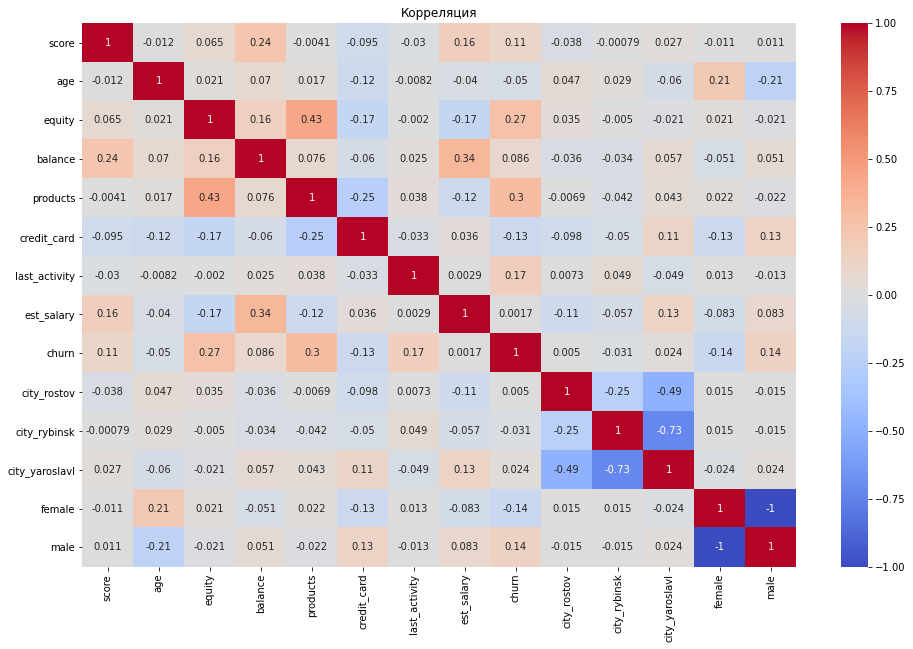

In [17]:
# Построим матрицу корреляции
corr = data.drop(['user_id'], axis=1).corr()
plt.figure(figsize=(16, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Корреляция')
plt.show()

***На основе полученных данных можно отметить, что:***

Мы видим, что зависимость между признаками слабо наблюдается. Balance больше всего коррелирует с est_salary (оценочный доход клиента) и от score (баллы кредитного скоринга), но и эти связи слабые.

Лучше оставить пропуски в balance и не удалять их, чтобы не терять большой пласт данных.

### Преобразование типов данных

In [18]:
# Преобразуем тип данных в столбце age и выполним проверку
data['age'] = data['age'].round().astype('int64')
data.age.dtype

dtype('int64')

***На основе полученных данных можно отметить, что:***

Тип данных в столбце age был изменен с float на int.

### Обработка аномалий

In [19]:
# После применения describe в прошлом пункте посмотри, сколько в таблице клиентов с 0 продуктов банка
data.query('products < 1')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_rostov,city_rybinsk,city_yaroslavl,female,male
8957,147837,962.0,Рыбинск,Ж,79,3,NaN,0,0,0,25063.96,1,0,1,0,1,0


In [20]:
# Удалим одну строку из таблицы, так как 0 продуктов является ошибкой или аномалией
data = data.query('products > 0') 
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9973 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         9973 non-null   int64  
 1   score           9973 non-null   float64
 2   city            9973 non-null   object 
 3   gender          9973 non-null   object 
 4   age             9973 non-null   int64  
 5   equity          9973 non-null   int64  
 6   balance         7695 non-null   float64
 7   products        9973 non-null   int64  
 8   credit_card     9973 non-null   int64  
 9   last_activity   9973 non-null   int64  
 10  est_salary      9973 non-null   float64
 11  churn           9973 non-null   int64  
 12  city_rostov     9973 non-null   uint8  
 13  city_rybinsk    9973 non-null   uint8  
 14  city_yaroslavl  9973 non-null   uint8  
 15  female          9973 non-null   uint8  
 16  male            9973 non-null   uint8  
dtypes: float64(3), int64(7), object(2

***На основе полученных данных можно отметить, что:***

Был найден один клиент с аномальным числом продуктов банка - 0. Такая аномалия была удалена из таблицы.

### Вывод

Названия столбцов были приведены к единому стилю, была выполнена проверка на наличие дубликатов, в том числе неявных, выполнено кодирование столбцов city и gender, а также проведен анализ пропусков.

Стало ясно, что пропуски в столбце balance сильно не коррелиут с другими признаками, и избавляться от них не стоит, так как пропадет большой пласт данных.

Исходя из пункта 2.2, мы заметили, что данные о возрасте отсутствуют у клиентов, у которых есть неявные дубликаты в user_id. При этом у таких клиентов указаны разные города, у одного или обоих из клиентов отстутсвуют данные о балансе или (и) возрасте, при этом оба клиента являются действующими, всегда совпадает пол этих клиентов и иногда совпадают баллы score. То есть появилось предположение, что эти клиенты сначала взаимодействовали с филиалом банка в одном городе, а потом перевелись на обслуживание в другой город. Однако не понятно, какой именно из дублей стоит удалять и стоит ли вообще. Такие пропуски и дубликаты можно оставить в таблице (тем более их количество не такое большое, всего 26 пропусков и 146 дублей).

Тип данных в age был преобразован в int. Был удален аномальный клиент с 0 продуктов банка.

## Исследовательский анализ данных

### Анализ распределения признаков, в том числе в разрезе оттока

Проанализируем отток клиентов по разным признакам (параметрам):

* количественные непрерывные признаки - найти интервалы, на которых отток выше, чем лояльность.
* категориальным (порядковые и номинальные) и количественные дискретные признаки - найти какое из значений признака склонно к оттоку.

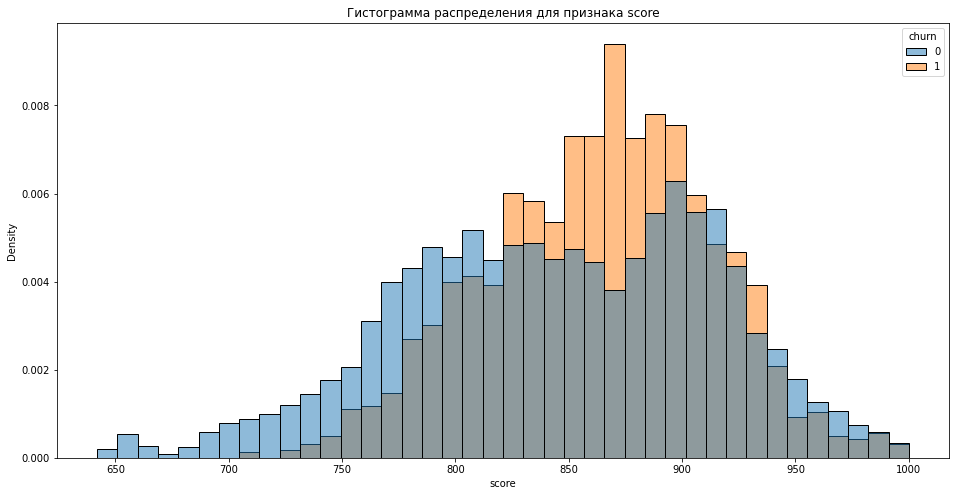

In [21]:
# Построим гистограмму для признака score (баллы кредитного скоринга), где 0 - действующие клиенты, 1 - отточные клиенты
plt.figure(figsize=(16, 8))
plt.title('Гистограмма распределения для признака score')
sns.histplot(data=data, x='score', hue='churn', stat='density', common_norm=False)
plt.show()

***На основе полученных данных можно отметить, что:***

Сразу заметно, что большинство отточных клиентов имеют баллы кредитного скоринга от 830 до 910 и 930-940. При этом пик приходится на 870 баллов. Если учитывать, что максимум баллов скоринга - это 1000, можно сказать, что эти показатели являюся средними и близкими к высоким. То есть, отточные клиенты имели достаточно неплохие баллы скоринга.

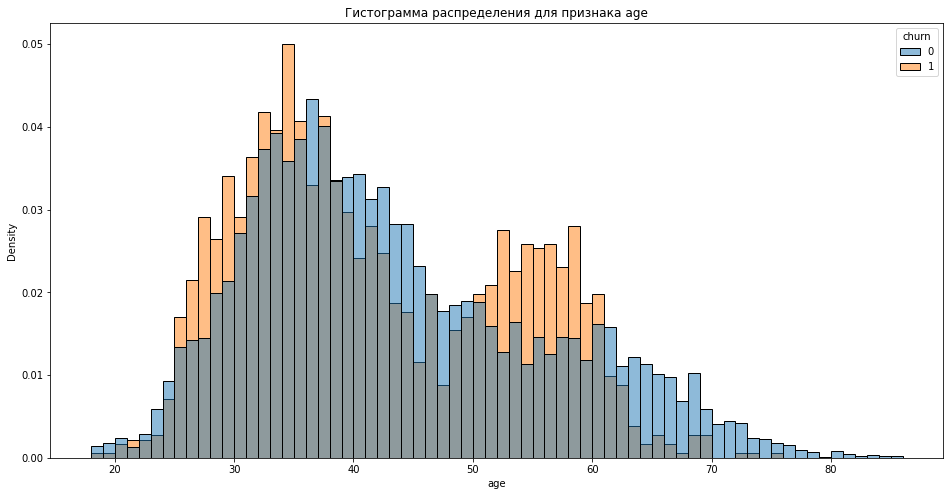

In [22]:
# Построим гистограмму для признака age, где 0 - действующие клиенты, 1 - отточные клиенты
plt.figure(figsize=(16, 8))
plt.title('Гистограмма распределения для признака age')
sns.histplot(data=data, x='age', hue='churn', stat='density', common_norm=False, bins=68)
plt.show()

***На основе полученных данных можно отметить, что:***

Мы видим, что отток клиентов чаще происходит для клиентов с возрастом от 25 до 36 лет и от 50 до 61 лет. Пик приходится на клиентов возрастом 35 лет.

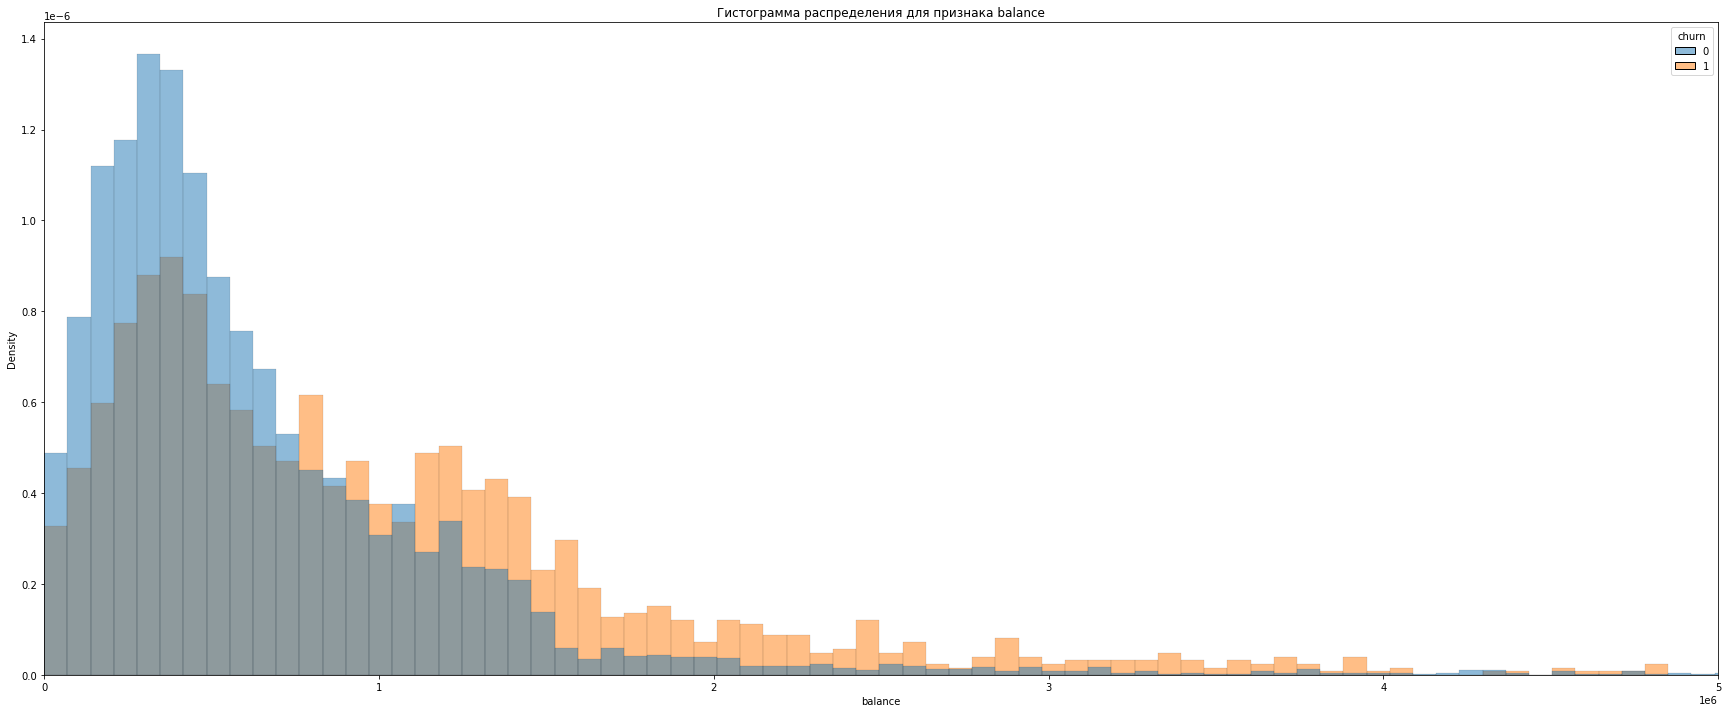

In [23]:
# Построим гистограмму для признака balance, где 0 - действующие клиенты, 1 - отточные клиенты
plt.figure(figsize=(30, 12))
plt.title('Гистограмма распределения для признака balance')
sns.histplot(data=data, x='balance', hue='churn', stat='density', common_norm=False)
plt.xlim(0, 5000000)
plt.show()

***На основе полученных данных можно отметить, что:***

У большинства отточных клиентов баланс средств был достаточно высокий - примерно от 800.000 р и вплоть до нескольких миллионов. 

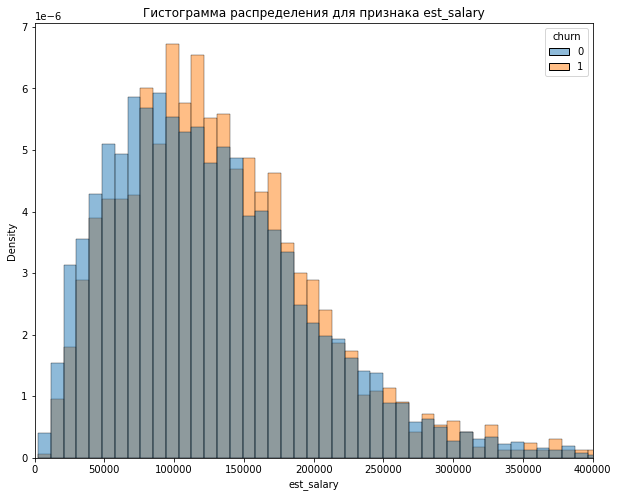

In [24]:
# Построим гистограмму для признака est_salary (оценочный доход клиента), где 0 - действующие клиенты, 1 - отточные клиенты
plt.figure(figsize=(10, 8))
plt.title('Гистограмма распределения для признака est_salary')
sns.histplot(data=data, x='est_salary', hue='churn', stat='density', common_norm=False)
plt.xlim(0, 400000)
plt.show()

***На основе полученных данных можно отметить, что:***

В среднем, отточные клиенты имеют зарплаты 80, 100-210 тысяч рублей.

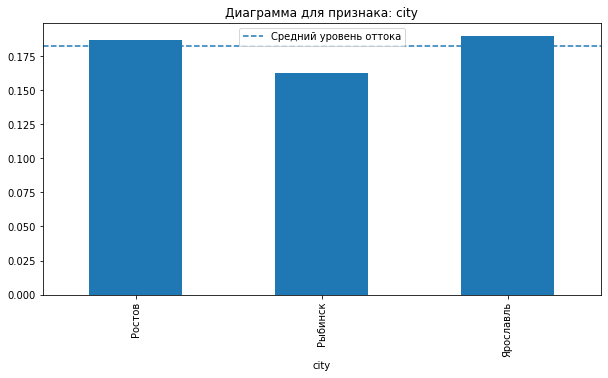

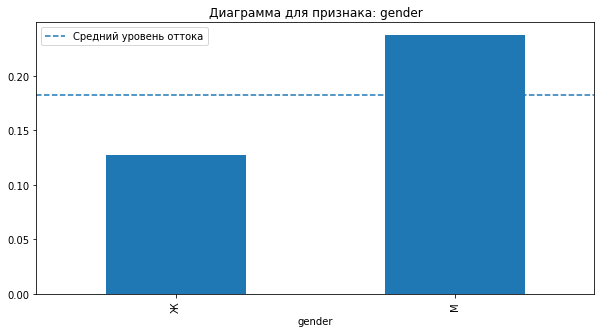

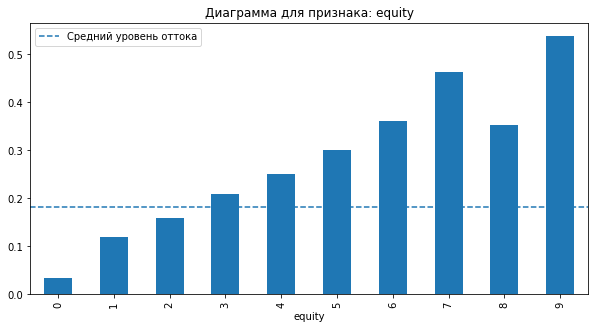

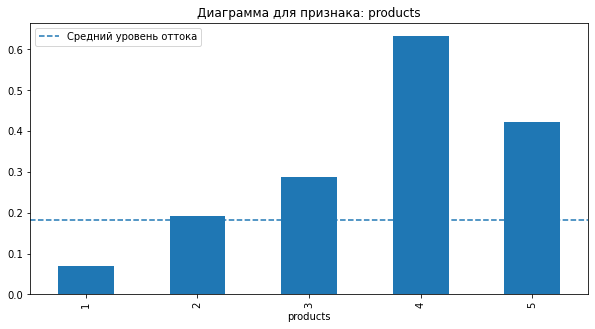

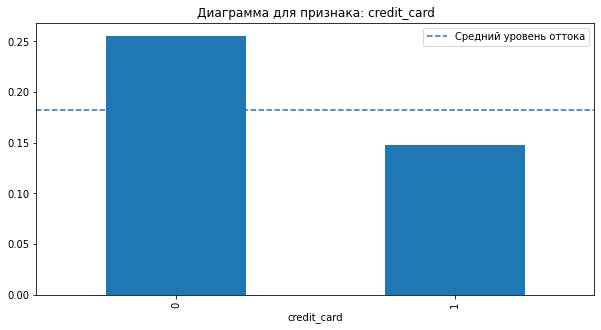

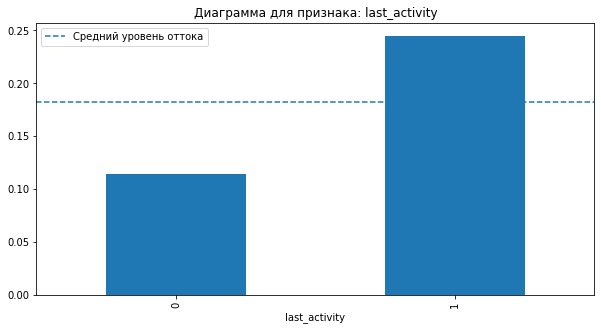

In [25]:
# Создадим цикл для среднего уровня оттока по категориальным/дискретным признакам
for a in ['city', 'gender', 'equity', 'products', 'credit_card', 'last_activity']:
    data.groupby(a).agg({'churn':'mean'}).plot.bar(figsize=(10,5)).axhline(data.churn.mean(), linestyle='--')
    plt.title(f'Диаграмма для признака: {a}')
    plt.legend(labels=['Средний уровень оттока'])
    plt.show()

***На основе полученных данных можно отметить, что:***

* Больше всего отточных клиентов в Ярославле и Ростове, но и в Рыбинске отток не намного меньше. То есть можно сказать, что отток клиентов по городам распределяется плюс-минус одинаково.
* Чаще отточными клиентами становятся мужчины.
* Чаще в отток попадают клиенты, которые имеют от 3 до 9 баллов (объектов) в собственности. Пик приходится на 9 объектов.
* Реже становятся отточными клиенты, которые пользуются 1 или 2 продуктами банка, чаще всего - клиенты с 4 продуктами.
* Реже становятся отточными клиенты с кредитными картами, чем те клиенты, которые не имеют кредиток.
* Чаще становятся отточными активные клиенты.

### Корреляционный анализ

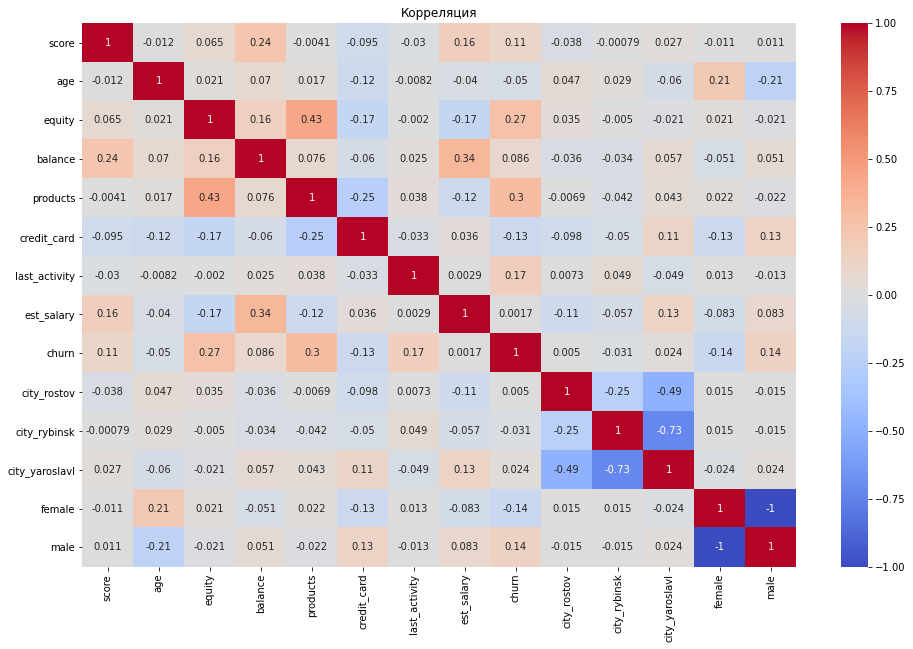

In [26]:
# Посмотрим на матрицу корреляции
plt.figure(figsize=(16, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Корреляция')
plt.show()

***На основе полученных данных можно отметить, что:***

По шкале Чеддока отток имеет очень слабую связь с products (кол-во продуктов, которыми пользуется клиент), equity (кол-во баллов собственности) и last_activity (активен клиент или нет). Также есть слабая связь с полом клиента.

### Анализ портретов клиентов в разрезе оттока

In [27]:
# Найдем моду по городу и полу
mode = {'city': [pd.Series.mode], 'gender': [pd.Series.mode]}
mode = data.groupby(['churn']).agg(mode)
mode

,city,gender
,mode,mode
churn,,
0,Ярославль,Ж
1,Ярославль,М


In [28]:
# Транспонируем таблицу и переимунуем названия колонок
mode = mode.T
mode.columns = ['Действующие клиенты', 'Отточные клиенты']
mode.index = ['city', 'gender']
mode

,Действующие клиенты,Отточные клиенты
city,Ярославль,Ярославль
gender,Ж,М


In [29]:
# Создаем сводную таблицу по остальным признакам
pivot = pd.pivot_table(data, columns = 'churn', values=['score', 'age', 'equity', 'balance', 'products', 'credit_card', 'est_salary'], aggfunc='mean')
pivot.columns = ['Действующие клиенты', 'Отточные клиенты'] 
pivot = pivot.round(2)
pivot

,Действующие клиенты,Отточные клиенты
age,43.02,41.43
balance,733031.63,1134458.21
credit_card,0.71,0.55
equity,2.38,3.76
est_salary,147674.64,148357.48
products,1.76,2.38
score,845.40,863.36


In [30]:
# Создадим столбец с относительной разницей между отточными и действующими клиентами
pivot['Относит. разница в %'] = (100 - (pivot['Отточные клиенты']/pivot['Действующие клиенты'] * 100)).abs()
pivot = pivot.round(2)
pivot

,Действующие клиенты,Отточные клиенты,Относит. разница в %
age,43.02,41.43,3.70
balance,733031.63,1134458.21,54.76
credit_card,0.71,0.55,22.54
equity,2.38,3.76,57.98
est_salary,147674.64,148357.48,0.46
products,1.76,2.38,35.23
score,845.40,863.36,2.12


In [31]:
# Соединим таблицы в одну
pivot_t = pd.concat([pivot, mode])
pivot_t 

,Действующие клиенты,Отточные клиенты,Относит. разница в %
age,43.02,41.43,3.70
balance,733031.63,1134458.21,54.76
credit_card,0.71,0.55,22.54
equity,2.38,3.76,57.98
est_salary,147674.64,148357.48,0.46
products,1.76,2.38,35.23
score,845.4,863.36,2.12
city,Ярославль,Ярославль,NaN
gender,Ж,М,NaN


***На основе полученных данных можно отметить, что:***

Получившийся портрет отточных клиентов: мужчина, возраст 41 год, клиент филиала банка в Ярославле, не имеет кредитную карту, имеет 3-4 объекта в собственности, пользуется как минимум 2 продуктами банка, имеет достаточно высокий балл кредитного скоринга - 863, так же имеет высокий баланс на счете (в районе 1.134.000 руб) и оценочный доход примерно 148.000 руб.

Получившийся портрет действующих клиентов: женщина, возраст 43 года, клиент филиала банка в Ярославле, имеет кредитную карту, имеет 2 объекта в собственности, пользуется 1-2 продуктами банка, имеет балл кредитного скоринга немного меньше, чем у отточного клиента - 845, баланс на счете меньше, чем у отточного клиента, и составляет примерно 733.000 руб., оценочный доход схожий - примерно 147.000 руб.

### Вывод

Мы нашли признаки, влияющие на отток клиентов:
* В целом, отток клиентов в городах плюс-минус равномерный, но немного ниже отток в Рыбинске.
* Чаще отточными клиентами становятся мужчины.
* Чаще в отток попадают клиенты, которые имеют больше 3 (и вплоть до 9) баллов (объектов) в собственности. 
* Чаще становятся отточными клиенты, которые пользуются больше, чем двумя продуктами банка.
* Реже становятся отточными клиенты с кредитными картами, чем те клиенты, которые не имеют кредиток.
* Чаще становятся отточными активные клиенты.
* Отток клиентов чаще происходит для клиентов с возрастом 25-36 лет и от 50-61 лет. Пик приходится на клиентов возрастом 35 года.
* Большинство отточных клиентов имеют баллы кредитного скоринга от 830 до 940. При этом пик приходится на 870 баллов. Эти показатели являюся близкими к высоким. 
* У большинства отточных клиентов баланс средств был достаточно высокий - примерно от 800.000 р и вплоть до нескольких миллионов. Это наталкивает на мысли о том, что, возможно, это средства, лежащие на вкладах или на накопительных счетах, куда кладут средства для накопления процентов по ним. И возможно, наш банк предлагает неочень высокие проценты по таким вкладам, а предложения сторонних банков лучше.
* В среднем, отточные клиенты имеют зарплаты 80-210 тысяч рублей.

Получившийся портрет отточных клиентов: мужчина, возраст 41 год, клиент филиала банка в Ярославле, не имеет кредитную карту, имеет 3-4 объекта в собственности, пользуется как минимум 2 продуктами банка, имеет достаточно высокий балл кредитного скоринга - 863, так же имеет высокий баланс на счете (в районе 1.134.000 руб) и оценочный доход примерно 148.000 руб.

Получившийся портрет действующих клиентов: женщина, возраст 43 года, клиент филиала банка в Ярославле, имеет кредитную карту, имеет 2 объекта в собственности, пользуется 1-2 продуктами банка, имеет балл кредитного скоринга немного меньше, чем у отточного клиента - 845, баланс на счете меньше, чем у отточного клиента, и составляет примерно 733.000 руб., оценочный доход схожий - примерно 147.000 руб.

## Проверка статистических гипотез

### Гипотеза 1: Средние доходы действующих и отточных клиентов равны

Сформулируем гипотезы. 
* Н0: средние доходы действующих и отточных клиентов равны. 
* Н1: средние доходы действующих и отточных клиентов не равны. 

Для проверки гипотез будем использовать ttest Стюдента, потому что выполнены три условия:
* Генеральные совокупности не зависят друг от друга. 
* Выборочные средние нормально распределены. 
* Дисперсии рассматриваемых генеральных совокупностей равны.

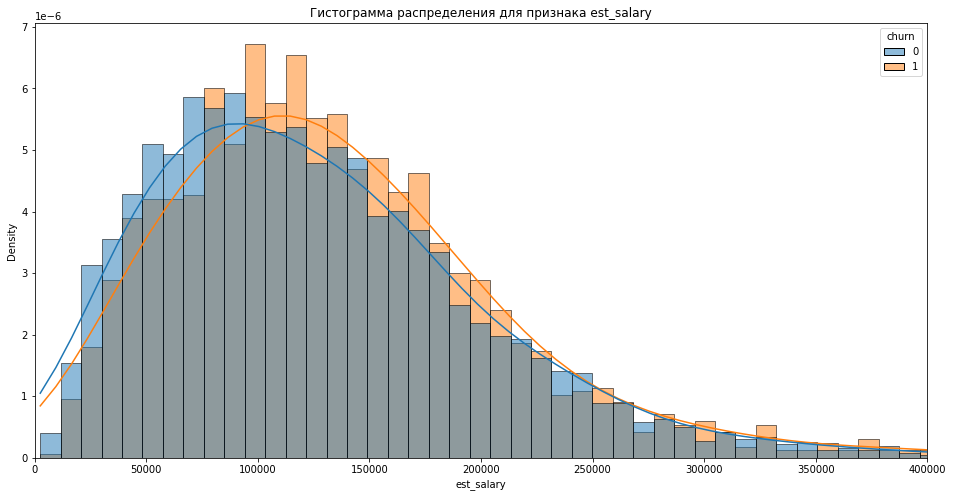

In [32]:
# Визуализируем распределение данных, добавив кривую плотности распределения, где 0 - действующие клиенты, 1 - отточные
plt.figure(figsize=(16,8))
sns.histplot(data=data, x='est_salary', hue='churn', stat='density', common_norm=False, kde=True)
plt.title('Гистограмма распределения для признака est_salary')
plt.xlim(0, 400000)
plt.show()

In [33]:
# Создадим переменные с информацией о доходах отточных и действующих клиентов
salary_churn = data[data['churn']==1]['est_salary']
salary_no_churn = data[data['churn']==0]['est_salary']
# Выведем на экран информацию о среднем доходе отточных и действующих клиентов
display('Средний доход отточных клиентов:', salary_churn.mean())
display('Средний доход действующих клиентов:', salary_no_churn.mean())

'Средний доход отточных клиентов:'

148357.48315731573

'Средний доход действующих клиентов:'

147674.63788105457

In [34]:
# Зададим уровень значимости 5%
alpha=0.05
# Проведем ttest
results = st.ttest_ind(salary_churn, salary_no_churn, equal_var = True)
display('p-value:', results.pvalue)
if results.pvalue < alpha:
    display('Отвергаем нулевую гипотезу')
else:
    display('Не получилось отвергнуть нулевую гипотезу')

'p-value:'

0.8500882387258035

'Не получилось отвергнуть нулевую гипотезу'

***На основе полученных данных можно отметить, что:***

После проведения t-теста у нас не получилось отвергнуть нулевую гипотезу, следовательно средние доходы отточных и действующих клиентов равны.

### Гипотеза 2: Средние балансы на счете действующих и отточных клиентов равны

Сформулируем гипотезы. 
* Н0: средние балансы на счете действующих и отточных клиентов равны. 
* Н1: средние балансы на счете действующих и отточных клиентов не равны. 

In [35]:
# Создадим таблицу balance_no_nan, куда попадут все строки таблицы, в которых имеется информация по балансу
balance_no_nan = data[data['balance'] >= 0]
# Создадим переменные с информацией о балансах отточных и действующих клиентов
balance_churn = balance_no_nan[balance_no_nan['churn']==1]['balance']
balance_no_churn = balance_no_nan[balance_no_nan['churn']==0]['balance']
# Выведем на экран информацию о балансах отточных и действующих клиентов
display('Средний баланс отточных клиентов:', balance_churn.mean())
display('Средний баланс действующих клиентов:', balance_no_churn.mean())

'Средний баланс отточных клиентов:'

1134458.2092912514

'Средний баланс действующих клиентов:'

733031.6301494313

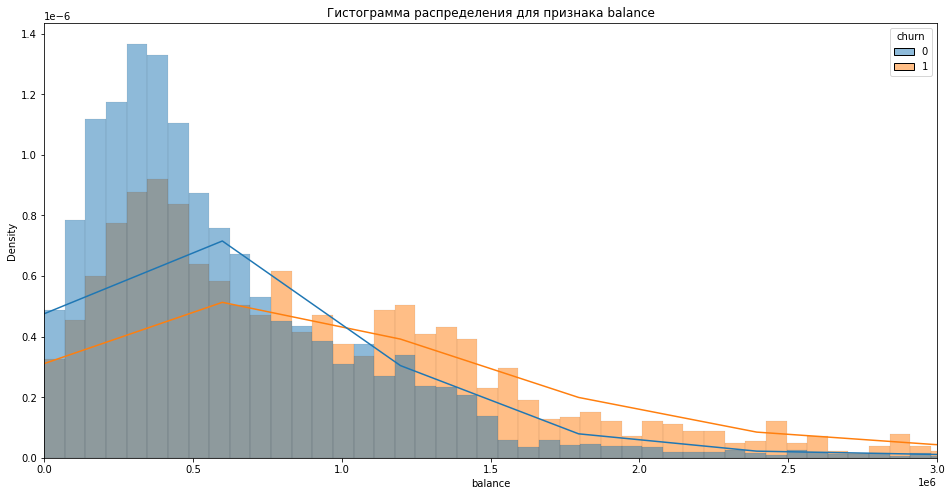

In [36]:
# Визуализируем распределение данных, добавив кривую плотности распределения, где 0 - действующие клиенты, 1 - отточные
plt.figure(figsize=(16,8))
sns.histplot(data=balance_no_nan, x='balance', hue='churn', stat='density', common_norm=False, kde=True)
plt.title('Гистограмма распределения для признака balance')
plt.xlim(0, 3000000)
plt.show()

In [37]:
# Зададим уровень значимости 5%
alpha=0.05
# Проведем ttest
results = st.ttest_ind(balance_churn, balance_no_churn, equal_var = True)
display('p-value:', results.pvalue)
if results.pvalue < alpha:
    display('Отвергаем нулевую гипотезу')
else:
    display('Не получилось отвергнуть нулевую гипотезу')

'p-value:'

4.3764190272075795e-14

'Отвергаем нулевую гипотезу'

***На основе полученных данных можно отметить, что:***

После проведения t-теста мы отвергаем нулевую гипотезу, следовательно средние балансы отточных и действующих клиентов не являюся равными.

### Вывод

В результате проверки обязательной гипотезы №1 "Средние доходы действующих и отточных клиентов равны" мы не смогли отвергнуть эту гипотезу. Следовательно средние доходы отточных и действующих клиентов равны.

В результате проверки гипотезы №2 "Средние балансы на счете действующих и отточных клиентов равны" мы отвергнули эту гипотезу. Следовательно средние балансы отточных и действующих клиентов не являюся равными.

## Подведение промежуточных итогов

После проверки двух гипотез можно прийти к следующим выводам: 
* Средние доходы отточных и действующих клиентов равны.
* Балансы на счетах отточных и действующих клиентов не являются равными. При этом средний баланс на счете у отточных клиентов составляет 1.134.000 руб., а у действующих клиентов - 733.000 руб. То есть разница явно присутствует.

Ту же разницу мы видим при описании портретов отточного и действующего клиента:

* Получившийся портрет отточных клиентов: мужчина, возраст 41 год, клиент филиала банка в Ярославле, не имеет кредитную карту, имеет 3-4 объекта в собственности, пользуется как минимум 2 продуктами банка, имеет достаточно высокий балл кредитного скоринга - 863, так же имеет высокий баланс на счете (в районе 1.134.000 руб) и оценочный доход примерно 148.000 руб.

* Получившийся портрет действующих клиентов: женщина, возраст 43 года, клиент филиала банка в Ярославле, имеет кредитную карту, имеет 2 объекта в собственности, пользуется 1-2 продуктами банка, имеет балл кредитного скоринга немного меньше, чем у отточного клиента - 845, баланс на счете меньше, чем у отточного клиента, и составляет примерно 733.000 руб., оценочный доход схожий - примерно 147.000 руб.

Также при поиске признаков, влияющих на отток клиентов, в одном из пунктов было установлено, что:

* У большинства отточных клиентов баланс средств был достаточно высокий - примерно от 800.000 р и вплоть до нескольких миллионов. Это наталкивает на мысли о том, что, возможно, это средства, лежащие на вкладах или на накопительных счетах, куда кладут средства для накопления процентов по ним. И возможно, наш банк предлагает неочень высокие проценты по таким вкладам, а предложения сторонних банков лучше.
* В целом, отток клиентов в городах плюс-минус равномерный, но немного ниже отток в Рыбинске.
* Чаще отточными клиентами становятся мужчины.
* Чаще в отток попадают клиенты, которые имеют больше 3 (и вплоть до 9) баллов (объектов) в собственности.
* Чаще становятся отточными клиенты, которые пользуются больше, чем двумя продуктами банка, при этом пик приходится на 4 продукта.
* Реже становятся отточными клиенты с кредитными картами, чем те клиенты, которые не имеют кредиток.
* Чаще становятся отточными активные клиенты.
* Отток клиентов чаще происходит для клиентов с возрастом 25-36 лет и от 50-61 год. Пик приходится на клиентов возрастом 35 лет.
* Большинство отточных клиентов имеют баллы кредитного скоринга от 830 до 940. При этом пик приходится на 870 баллов. Эти показатели являюся близкими к высоким.
* В среднем, отточные клиенты имеют зарплаты 80-210 тысяч рублей.


## Сегментация пользователей

### Объединяя признаки отточности, сформировать сегменты

Исходя из подведенных выше промежуточных итогов, можно выделить несколько сегментов отточных клиентов, исходя из различных признаков:

* пол
* возраст
* город
* количество баллов собственности
* количество продуктов банка
* наличие кредитной карты
* активность клиента

In [38]:
# Создадим таблицу с отточными клиентами
churn_clients = data.query('churn == 1')

In [39]:
# Создаем сегмент 1 с активными клиентами, у которых 3 и более баллов собственности
segment_1 = churn_clients.query('3<=equity and last_activity==1')
display(f'Количество клиентов в сегменте №1: {len(segment_1)}')
# Создадим срез клиентов с подобными признаками
clients_1 = data.query('3<=equity and last_activity==1')
display(f'Процент оттока от общего числа клиентов с подобными признаками: {clients_1["churn"].mean()*100} %')

'Количество клиентов в сегменте №1: 1068'

'Процент оттока от общего числа клиентов с подобными признаками: 36.57534246575342 %'

In [40]:
# Создаем сегмент 2 с клиентами, обслуживающимися в Ярославле, у которых 2 и более продуктов банка
segment_2 = churn_clients.query('2<=products and city_yaroslavl==1')
display(f'Количество клиентов в сегменте №2: {len(segment_2)}')
# Создадим срез клиентов с подобными признаками
clients_2 = data.query('2<=products and city_yaroslavl==1')
display(f'Процент оттока от общего числа клиентов с подобными признаками: {clients_2["churn"].mean()*100} %')

'Количество клиентов в сегменте №2: 987'

'Процент оттока от общего числа клиентов с подобными признаками: 25.61640280301064 %'

In [41]:
# Создаем сегмент 3 с активными клиентами в возрасте 25-61 год, у которых 2 и более продуктов банка и нет кредитных карт 
segment_3 = churn_clients.query('last_activity==1 and 2<=products and credit_card==0 and 25<age<61')
display(f'Количество клиентов в сегменте №3: {len(segment_3)}')
# Создадим срез клиентов с подобными признаками
clients_3 = data.query('last_activity==1 and 2<=products and credit_card==0 and 25<age<61')
display(f'Процент оттока от общего числа клиентов с подобными признаками: {clients_3["churn"].mean()*100} %')

'Количество клиентов в сегменте №3: 562'

'Процент оттока от общего числа клиентов с подобными признаками: 45.43249797898141 %'

### Приоретизация сегментов

Расположим сегменты по мере убывания отточных клиентов.

1. Сегмент 3 с активными клиентами в возрасте 25-61 год, у которых 2 и более продуктов банка и нет кредитных карт. Уровень оттока составляет 45.4%.
2. Сегмент 1 с активными клиентами, у которых 3 и более баллов собственности. Уровень оттока составляет 36.5%.
3. Сегмент 2 с клиентами, обслуживающимися в Ярославле, у которых 2 и более продуктов банка. Уровень оттока составляет 25.6%.

### Вывод

Были созданы 8 сегментов отточных клиентов, в которые попали не менее 457 человек. Далее сегменты были приоретизированы в порядке убывания процента отточных клиентов:

* На первом месте - сегмент 3, в который вошли активные клиенты в возрасте 25-61 год, у которых 2 и более продуктов банка и нет кредитных карт. 
* На втором месте - сегмент 1, куда вошли активные клиенты, у которых 3 и более баллов собственности. 
* На третьем месте - сегмент 2 с клиентами, обслуживающимися в Ярославле, у которых 2 и более продуктов банка.

## Вывод и рекомендации по отобранным сегментам

1. В ходе загрузки мы получили таблицу data, где содержатся 12 столбцов и 10000 строк. 

2. После предобработки данных названия столбцов были приведены к единому стилю, была выполнена проверка на наличие дубликатов, кодирование столбцов city и gender, а также проведен анализ пропусков. Стало ясно, что пропуски в столбце balance сильно не коррелиут с другими признаками, и избавляться от них мы нестали, так как пропал бы большой пласт информации. Также было замечено, что данные о возрасте отсутствуют у клиентов, у которых есть неявные дубликаты в user_id. При этом у таких клиентов указаны разные города, у одного или обоих из клиентов отстутсвуют данные о балансе или (и) возрасте, при этом оба клиента являются действующими, всегда совпадает пол этих клиентов и иногда совпадают баллы score. Появилось предположение, что эти клиенты сначала взаимодействовали с филиалом банка в одном городе, а потом перевелись на обслуживание в другой город.

3. В ходе исследовательского анализа данных мы нашли признаки, влияющие на отток клиентов:
* Чаще отточными клиентами становятся мужчины.
* Чаще в отток попадают клиенты, которые имеют больше 3 (и вплоть до 9) баллов (объектов) в собственности.
* Чаще становятся отточными клиенты, которые пользуются больше, чем двумя продуктами банка.
* Чаще становятся отточными клиенты, которые не имеют кредиток.
* Чаще становятся отточными активные клиенты.
* Отток клиентов чаще происходит для клиентов с возрастом 25-33 лет и от 50-60 лет. Но при сегментации мы взяли период в целом от 25 до 60 лет.
* Большинство отточных клиентов имеют баллы кредитного скоринга от 830 до 940. При этом пик приходится на 870 баллов. Эти показатели являюся близкими к высоким и высокими.
* У большинства отточных клиентов баланс средств был достаточно высокий - примерно от 800.000 р и вплоть до нескольких миллионов. Это наталкивает на мысли о том, что, возможно, это средства, лежащие на вкладах или на накопительных счетах, куда кладут средства для накопления процентов по ним. И возможно, наш банк предлагает неочень высокие проценты по таким вкладам, а предложения сторонних банков лучше.
* В среднем, отточные клиенты имеют зарплаты 80-210 тысяч рублей.
* В целом, отток клиентов в городах плюс-минус равномерный, но немного ниже отток в Рыбинске.

4. Получившийся портрет отточного клиента: мужчина, возраст 41 год, клиент филиала банка в Ярославле, не имеет кредитную карту, имеет 3-4 объекта в собственности, пользуется как минимум 2 продуктами банка, имеет достаточно высокий балл кредитного скоринга - 863, так же имеет высокий баланс на счете (в районе 1.133.993 руб) и оценочный доход примерно 148.000 руб.

Получившийся портрет действующего клиента: женщина, возраст 43 года, клиент филиала банка в Ярославле, имеет кредитную карту, имеет 2 объекта в собственности, пользуется 1-2 продуктами банка, имеет балл кредитного скоринга немного меньше, чем у отточного клиента - 845, баланс на счете меньше, чем у отточного клиента, и составляет примерно 734.000 руб., оценочный доход схожий - примерно 147.000 руб.

5. Была проведена проверка двух статистических гипотез. Для проверки гипотез был использован ttest Стюдента, потому что генеральные совокупности не зависят друг от друга, выборочные средние нормально распределены, дисперсии рассматриваемых генеральных совокупностей равны. 

* В результате проверки обязательной гипотезы №1 "Средние доходы действующих и отточных клиентов равны" мы не смогли отвергнуть эту гипотезу. Следовательно средние доходы отточных и действующих клиентов равны.
* В результате проверки гипотезы №2 "Средние балансы на счете действующих и отточных клиентов равны" мы отвергнули эту гипотезу. Следовательно средние балансы отточных и действующих клиентов не являюся равными.

6. Были выделены 3 сегмента отточных клиентов, исходя из различных признаков: пол, возраст, город, количество баллов собственности, количество продуктов банка, наличие кредитной карты, активность клиента. В сегменты попали не менее 562 человек. Далее сегменты были приоретизированы в порядке убывания процента отточных клиентов.
* Сегмент 3 с активными клиентами в возрасте 25-61 год, у которых 2 и более продуктов банка и нет кредитных карт. Уровень оттока составляет 45.4%.
* Сегмент 1 с активными клиентами, у которых 3 и более баллов собственности. Уровень оттока составляет 36.5%.
* Сегмент 2 с клиентами, обслуживающимися в Ярославле, у которых 2 и более продуктов банка. Уровень оттока составляет 25.6%.

Также, в целом, можно сделать вывод, что клиенты, попавшие в отток, имеют достаточно высокие суммы на счете, не владеют кредитными картами, имеют более трех объектов в собственности, являются достаточно активными клиентами и пользуются более, чем двумя продуктами банка. То есть, это достаточно обеспеченные и состоятельные люди. 

### Рекомендации

**Сначала я опишу общие рекомендации для всех сегментов:**
* Предложить клиентам повышенный процент на остаток на счете.
* Предложить клиентам индивидуальные условия и повышенный процент по вкладам и счетам-копилкам.
* Предложить клиентам открыть в банке Индивидуальный инвестиционный счет (Цель ИИС, как и других подобных счетов — стимулировать людей самостоятельно копить на крупные финансовые цели, в том числе на будущую пенсию. Человек получает налоговые льготы от государства, но при этом ограничен в досрочном выводе денег.)
* Предложить клиентам повышенный кешбэк за различные покупки по картам. (категории можно менять из месяца в месяц).
* Предложить клиентам премиальное обслуживание в банке (если они еще не являются премиальными клиентами).
* Предложить клиентам консьерж-сервис (это команда специальных сотрудников, которые могут предоставить нужную информацию или различные услуги. Такие личные помощники организуют деловой график и досуг, поездку и праздник. Как правило, премиальные клиенты банков могут бесплатно пользоваться услугами консьерж-сервиса, Кроме того, за отдельную плату ими может воспользоваться любой желающий).
* Проработать тексты и оформление сообщений и рассылок с информированием для клиентов в приложении, а так же в почте: информация о выгоде (повышенный кешбэк, процент и тд) должна выделяться и бросаться в глаза, письмо должно быть оформлено в общей стилистике банка, при этом информация должна быть четкой и сразу понятной.

**Дополнительные рекомендации:**

1. **Сегмент 3 с активными клиентами в возрасте 25-61 год, у которых 2 и более продуктов банка и нет кредитных карт. Уровень оттока составляет 45.4%**:
Можно сказать, что это основной портрет отточного клиента банка. Этот клиент имеет достаточную сумму на счетах, у него нет обязательной необходимости в кредитной карте.
* Таким клиентам точно будут важны повышенный процент на остаток на счете и повышенный процент по вкладам и счетам-копилкам
* Предложить клиентам повышенный кешбэк за различные покупки: для мужчин - за отплату в ресторанах, азс, супермаркетах, спортивных магазинах, магазинах для ремонта, магазинах техники и рыболовных магазинах,  магазинах одежды и детских магазинах, аптеках, кофейнях и т.д. (категории можно менять из месяца в месяц); для женщин - за отплату в магазинах косметики, парфюмерии, одежды, стедиях красоты (салоны маникюра, парикмахерские, массаж), студиях йоги, пилатеса, танцев и т.д., ресторанах, азс, супермаркетах, детских магазинах, книжных, аптеках, кофейнях и т.д. (категории можно менять из месяца в месяц) 
* Предложить клиентам страхование объектов собственности (недвижимости, автомобилей и т.д.) по выгодным ценам.
* Предложить выгодные условия (пониженный процент) по ипотечным программам.
* Предложить клиентам обслуживание в НПФ банка (если таковой имеется).


2. **Сегмент 1 с активными клиентами, у которых 3 и более баллов собственности. Уровень оттока составляет 36.5%**:
Можно предположить, что это сегмент достаточно обеспеченных клиентов, у которых в собственности как минимум 3 объекта, а как максимум - 9! 
* Предложить клиентам повышенный кешбэк за различные покупки: для мужчин - за отплату в ресторанах, азс, супермаркетах, спортивных магазинах, магазинах для ремонта, магазинах техники и рыболовных магазинах,  магазинах одежды и детских магазинах, аптеках, кофейнях и т.д. (категории можно менять из месяца в месяц); для женщин - за отплату в магазинах косметики, парфюмерии, одежды, стедиях красоты (салоны маникюра, парикмахерские, массаж), студиях йоги, пилатеса, танцев и т.д., ресторанах, азс, супермаркетах, детских магазинах, книжных, аптеках, кофейнях и т.д. (категории можно менять из месяца в месяц) 
* Предложить клиентам страхование объектов собственности (недвижимости, автомобилей и т.д.) по выгодным ценам.
* Предложить клиентам страхование ремонта (от затопления, пожара и т.д.).
* Предложить выгодные условия (пониженный процент) по ипотечным программам.
* Предложить клиентам обслуживание в НПФ банка (если таковой имеется).

3. **Сегмент 2 с клиентами, обслуживающимися в Ярославле, у которых 2 и более продуктов банка. Уровень оттока составляет 25.6%**:
* Предоставить клиентам удобное обслуживание в офисе в Ярославле - минимальное ожидание в очереди (например, 10 минут максимум), быстрое решение проблем и задач, постеры с информацией о новых программах банка на стенах в зале ожидания, достаточное посадочное количество мест в зале ожидания, заботу о клиентах, воду и приветственные конфетки:)
* Предложить клиентам повышенный кешбэк за различные покупки: для мужчин - за отплату в ресторанах, азс, супермаркетах, спортивных магазинах, магазинах техники и рыболовных магазинах,  магазинах одежды и детских магазинах, аптеках, кофейнях и т.д. (категории можно менять из месяца в месяц); для женщин - за отплату в магазинах косметики, парфюмерии, одежды, стедиях красоты (салоны маникюра, парикмахерские, массаж), студиях йоги, пилатеса, танцев и т.д., ресторанах, азс, супермаркетах, детских магазинах, книжных, аптеках, кофейнях и т.д. (категории можно менять из месяца в месяц) 
* Предложить клиентам оформить кредитную карту
* Предложить выгодные условия по ипотечным программам

## Подготовка презентации и дашборда

Ссылка на презентацию: https://docs.google.com/presentation/d/12W4Eijkehf0yrU0--BxOrBmSNbLhS1ZtfyNUbObUYCk/edit?usp=sharing